<h1 style = "color: green"> Esercitazione 10 </h1>

In questo esercizio applichiamo tecniche di programmazione parallela alla risoluzione del problema del commesso viaggiatore (TSP) per le 50 capitali degli stati degli USA, sfruttando la libreria MPI (opzione 1 dell'esercizio 10.1, che qui è omesso perché consiste nell'aggiungere la parallelizzazione al codice dell'esercitazione 9).

<h3 style = "color: blue"> Esercizio 10.2 </h3>

Studiamo la differenza tra i risultati ottenuti sfruttando più processi quando questi comunicano tra loro scambiandosi la miglior soluzione ogni $N_{migr}$ generazioni oppure quando sono isolati.  
Ovviamente il primo caso, se non risulterà migliore del secondo, di sicuro non dovrà essere peggiore.  

Consideriamo la Terra come una sfera, per semplicità poniamo $r=1$. Come funzione costo usiamo $
L^{(1)}(\vec{x}_1, \vec{x}_2, \dots, \vec{x}_N) = \sum_{i=1}^{N} |\vec{x}_i-\vec{x}_{i+1}|
$ in 2D, dove gli $\vec{x}_i$ sono le posizioni sulla 2-sfera, rappresentate da latitudine e longitudine. $
L^{(1)}$ è quindi la somma delle distanze di cerchio massimo tra ogni città e la successiva nel percorso.  

Usiamo 6 processi per effettuare la ricerca del percorso ottimale in parallelo, ognuno dei quali esegue l'algoritmo genetico dell'esercitazione 9 con una popolazione di 1000 cromosomi per 300 generazioni.

<h4> Ricerche in parallelo indipendenti </h4>

Il percorso migliore trovato quando i processi non comunicano tra loro è riportato nel grafico sottostante. Questo metodo equivale a eseguire l'algoritmo 6 volte di fila con 6 semi diversi per il generatore di numeri pseudo-casuali (in realtà il seme è lo stesso, cambiano i numeri primi usati dall'algoritmo RANNYU).

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


nProcesses = 6


# imports latitude and longitude and name of the cities
def importPositions(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    length = len(lines)

    theta, phi = np.empty(length), np.empty(length)
    names = np.empty(length, dtype = object)
    for i in range(1, length):
        values = lines[i].split()
        names[i - 1] = values[1]
        theta[i - 1], phi[i - 1] = float(values[3]), float(values[2])

    dataFile.close()

    return theta, phi, names



# reads the best path found
def importCities(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    nLines = len(lines)
    length = len(lines[0].split())
    scores = np.empty(nLines)
    
    for i in range(nLines):
        values = lines[i].split()
        scores[i] = values[-1]
    
    best = 0.
    iBest = 0
    for i in range(nLines):
        if (scores[i] > best):
            iBest = i
            best = scores[i]
    
    values = lines[iBest].split()
    length = len(values) - 1

    cities = np.empty(length, dtype = int)
    for i in range(length):
        cities[i] = int(values[i])

    dataFile.close()

    return cities, best, length



# imports values of the average path and best path lengths (L^(1))
def loadFile(name):
    dataFile = open(name, "r")
    lines = dataFile.readlines()
    fileLength = len(lines)
    content = np.empty(fileLength)

    for i in range(fileLength):
        content[i] = float(lines[i])

    dataFile.close()

    return content, fileLength

il miglior percorso trovato ha L^(1) = 4.172264


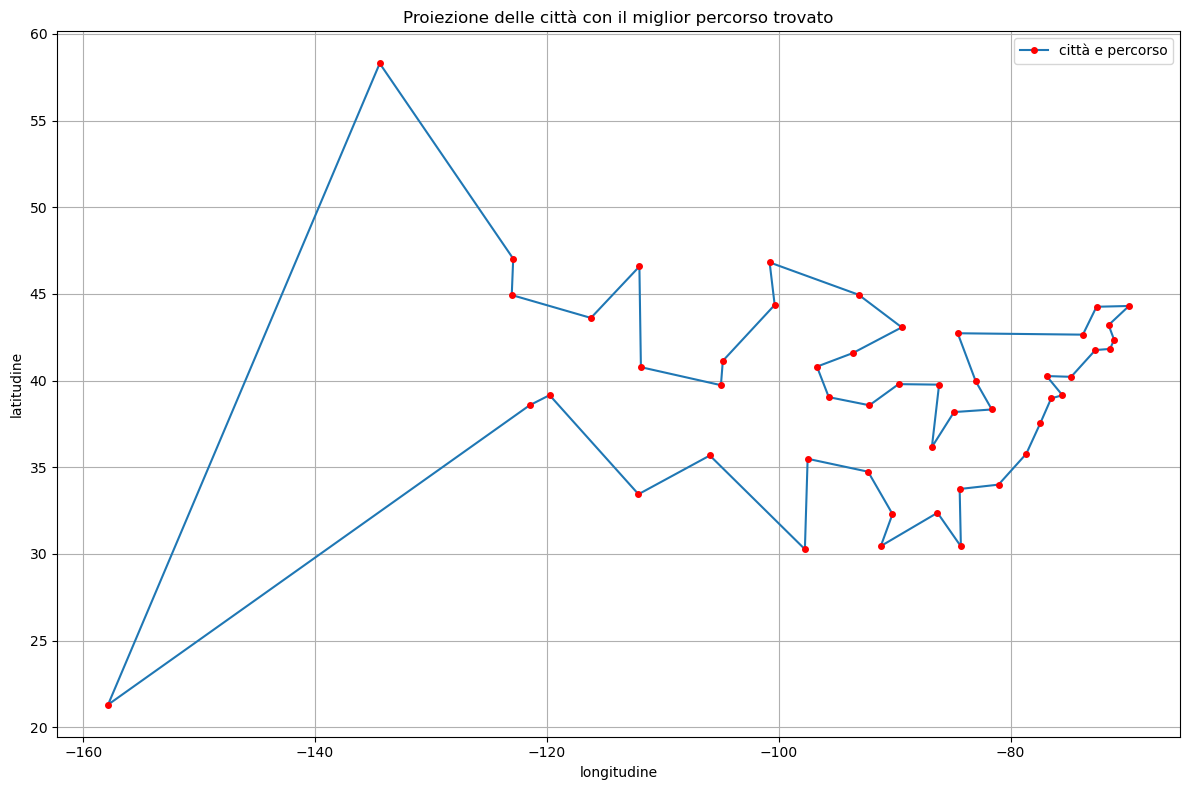

In [2]:
theta, phi, names = importPositions("code/American_capitals.dat")
cities, bestScore, nCities = importCities("code/independent/best.out")

print("il miglior percorso trovato ha L^(1) = %f" % (1. / bestScore))


thetaOrder, phiOrder = np.empty(nCities), np.empty(nCities)

for i in range(nCities):
    thetaOrder[i] = theta[cities[i] - 1]
    phiOrder[i] = phi[cities[i] - 1]

    
fig = plt.figure(figsize = (12, 8))


# draw last segment first so it is rendered under the dots
plt.plot([phiOrder[nCities - 1], phiOrder[0]], [thetaOrder[nCities - 1], thetaOrder[0]])

plt.plot(phiOrder, thetaOrder, "o-", color = "#1f77b4", ms = 4, mfc = "red", mec = "red", label = "città e percorso")


plt.title("Proiezione delle città con il miglior percorso trovato")
plt.xlabel("longitudine")
plt.ylabel("latitudine")


plt.legend()
plt.grid(True)
fig.tight_layout()
plt.show()

Ora possiamo studiare l'andamento del valore di $L^{(1)}$ in funzione delle generazioni per tutti processi. Confrontiamo il valore migliore con la media sulla metà della popolazione solo per il processo migliore, altrimenti il grafico risulta troppo affollato.

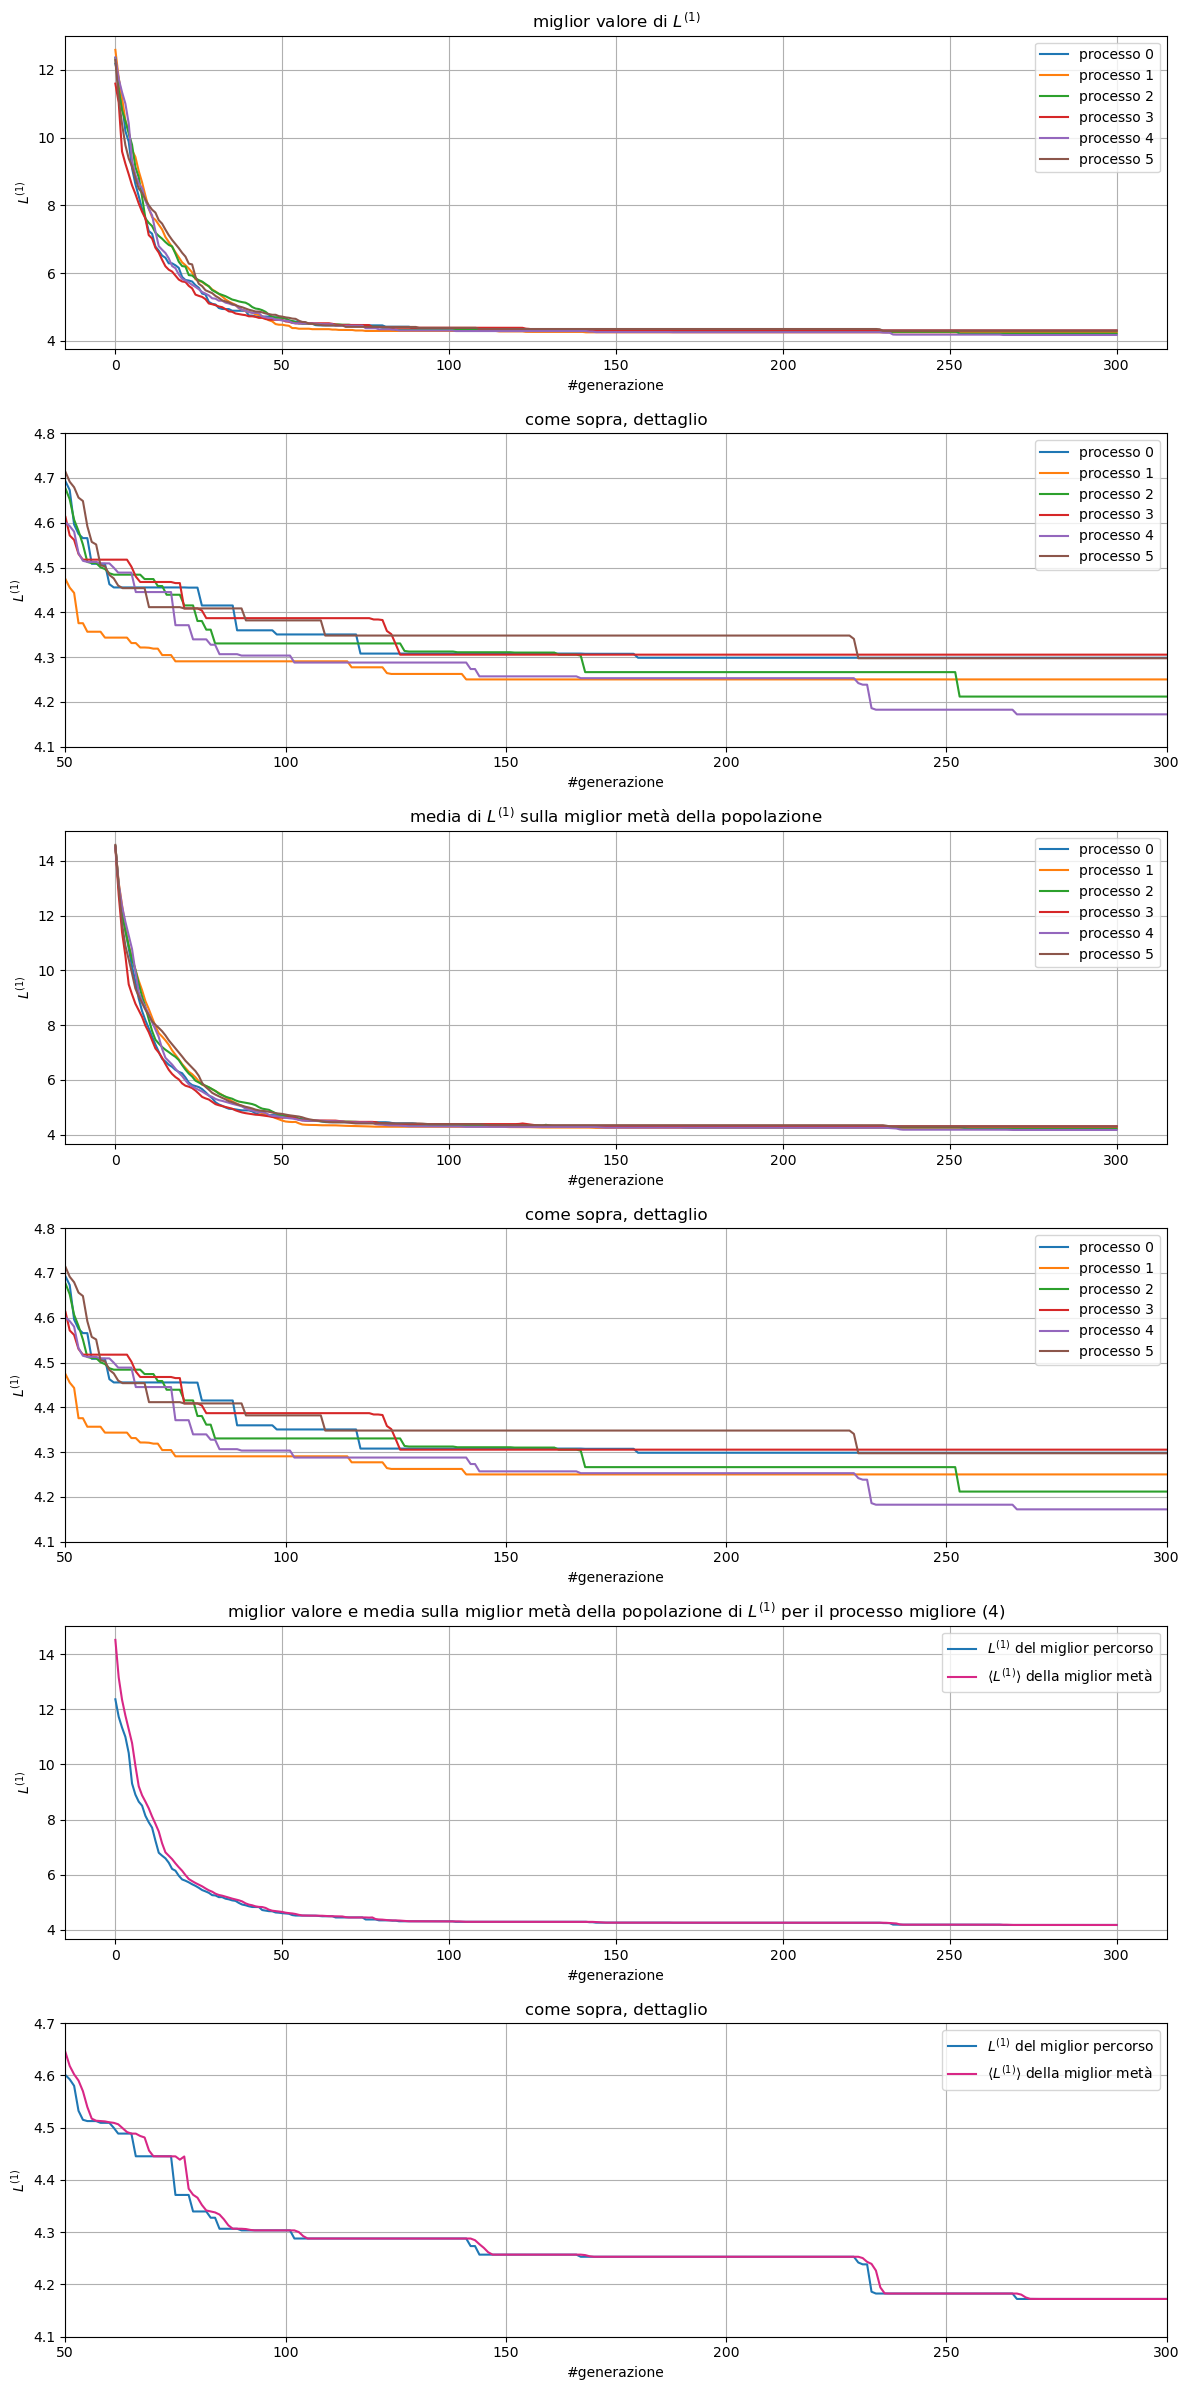

In [3]:
fig, ax = plt.subplots(6, 1, figsize = (12, 24))

bestProc = 0
bestPath = 10000
for i in range(nProcesses):
    # plot best value of L^1 over generations
    best, nGens = loadFile("code/independent/path_" + str(i) + ".out")
    x = np.arange(nGens)
    ax[0].plot(x, best, label = "processo " + str(i))
    ax[1].plot(x, best, label = "processo " + str(i))

    # plot average value of L^1 on the best half of the populazion over generations
    mean, nGens = loadFile("code/independent/average_" + str(i) + ".out")
    ax[2].plot(x, mean, label = "processo " + str(i))
    ax[3].plot(x, best, label = "processo " + str(i))
    
    if (best[-1] < bestPath):
        bestPath = best[-1]
        bestProc = i

    
# compare best and average for the best process
best, nGens = loadFile("code/independent/path_" + str(bestProc) + ".out")
x = np.arange(nGens)
ax[4].plot(x, best, label = "$L^{(1)}$ del miglior percorso")
ax[5].plot(x, best, label = "$L^{(1)}$ del miglior percorso")

mean, nGens = loadFile("code/independent/average_" + str(bestProc) + ".out")
ax[4].plot(x, mean, color = "#d82786", label = r"$\langle L^{(1)} \rangle$ della miglior metà")
ax[5].plot(x, mean, color = "#d82786", label = r"$\langle L^{(1)} \rangle$ della miglior metà")
    
    
ax[0].set(title = "miglior valore di $L^{(1)}$", xlabel = "#generazione", ylabel = "$L^{(1)}$")
ax[0].legend()
ax[0].grid(True)

ax[1].set(title = "come sopra, dettaglio", xlabel = "#generazione", ylabel = "$L^{(1)}$", xlim = (50, 300), ylim = (4.1, 4.8))
ax[1].legend()
ax[1].grid(True)

ax[2].set(title = "media di $L^{(1)}$ sulla miglior metà della popolazione", xlabel = "#generazione", ylabel = "$L^{(1)}$")
ax[2].legend()
ax[2].grid(True)

ax[3].set(title = "come sopra, dettaglio", xlabel = "#generazione", ylabel = "$L^{(1)}$", xlim = (50, 300), ylim = (4.1, 4.8))
ax[3].legend()
ax[3].grid(True)

ax[4].set(title = "miglior valore e media sulla miglior metà della popolazione di $L^{(1)}$ per il processo migliore (%i)" % bestProc, xlabel = "#generazione", ylabel = "$L^{(1)}$")
ax[4].legend()
ax[4].grid(True)

ax[5].set(title = "come sopra, dettaglio", xlabel = "#generazione", ylabel = "$L^{(1)}$", xlim = (50, 300), ylim = (4.1, 4.7))
ax[5].legend()
ax[5].grid(True)


fig.tight_layout()
plt.show()

Notiamo come il comportamento dei vari processi sia molto diverso. Il processo 3 (rosso) trova un minimo locale attorno alla generazione 125 e vi resta intrappolato; altri invece restano in un minimo locale per molte generazioni e poi riescono a uscirne. Il processo 1 (arancione) sembra convergere più rapidamente degli altri, ma resta anch'esso intrappolato in un minimo locale.  
Anche in questo caso la media converge entro poche generazioni al valore migliore di $L^{(1)}$.

<h4> Ricerche in parallelo con scambio di informazione </h4>

Riportiamo gli stessi grafici del caso precedente.  
Questa volta però il calcolo parallelo dovrebbe permettere, in teoria, di trovare risultati migliori, poiché non si tratta più di compiere 6 ricerche del minimo separate, ma i vari processi si scambiano il miglior risultato trovato in modo casuale ogni $N_{migr}=20$ generazioni. In questo modo, i processi bloccati in un minimo locale hanno una possibilità in più di uscirne e, a ogni migrazione, più processi hanno la possibilità di far evolvere il miglior cromosoma contemporaneamente (ci aspettiamo che il processo che lo ha trovato ne abbia più una copia).

il miglior percorso trovato ha L^(1) = 4.121196


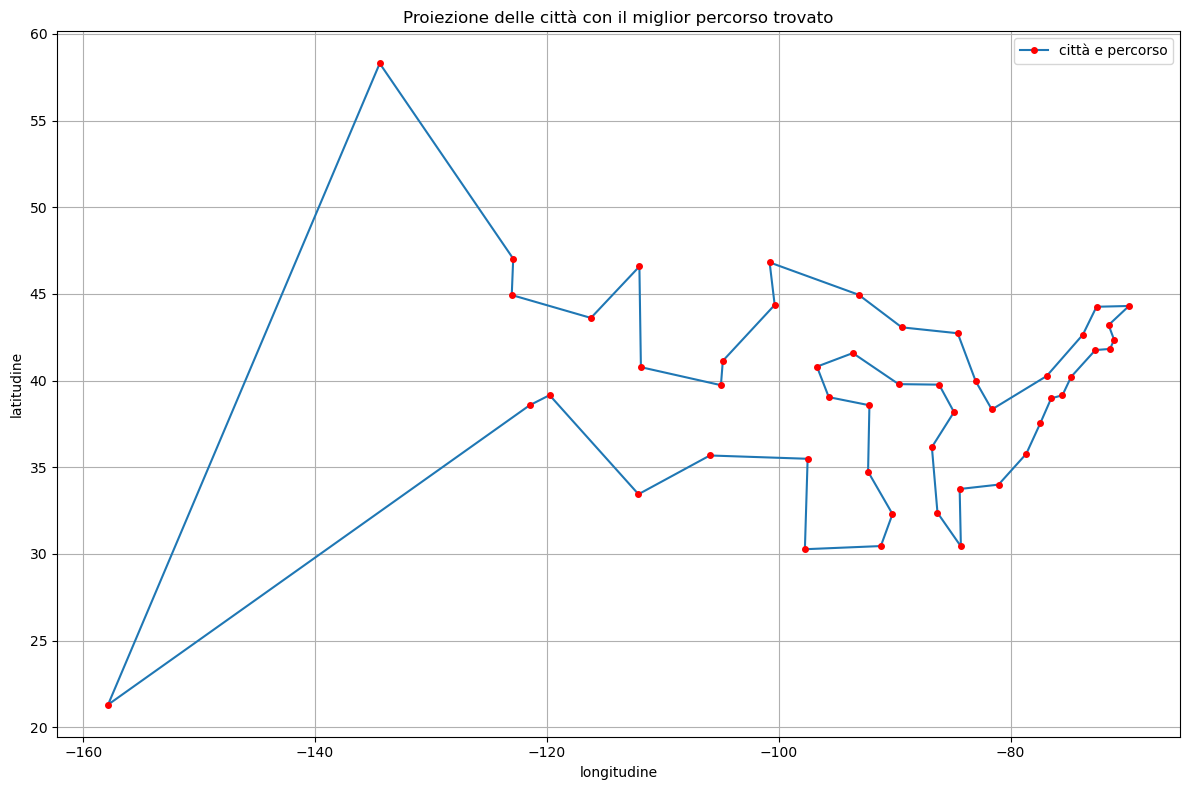

In [4]:
theta, phi, names = importPositions("code/American_capitals.dat")
cities, bestScore, nCities = importCities("code/exchange/best.out")

print("il miglior percorso trovato ha L^(1) = %f" % (1. / bestScore))


thetaOrder, phiOrder = np.empty(nCities), np.empty(nCities)

for i in range(nCities):
    thetaOrder[i] = theta[cities[i] - 1]
    phiOrder[i] = phi[cities[i] - 1]

    
fig = plt.figure(figsize = (12, 8))


# draw last segment first so it is rendered under the dots
plt.plot([phiOrder[nCities - 1], phiOrder[0]], [thetaOrder[nCities - 1], thetaOrder[0]])

plt.plot(phiOrder, thetaOrder, "o-", color = "#1f77b4", ms = 4, mfc = "red", mec = "red", label = "città e percorso")


plt.title("Proiezione delle città con il miglior percorso trovato")
plt.xlabel("longitudine")
plt.ylabel("latitudine")


plt.legend()
plt.grid(True)
fig.tight_layout()
plt.show()

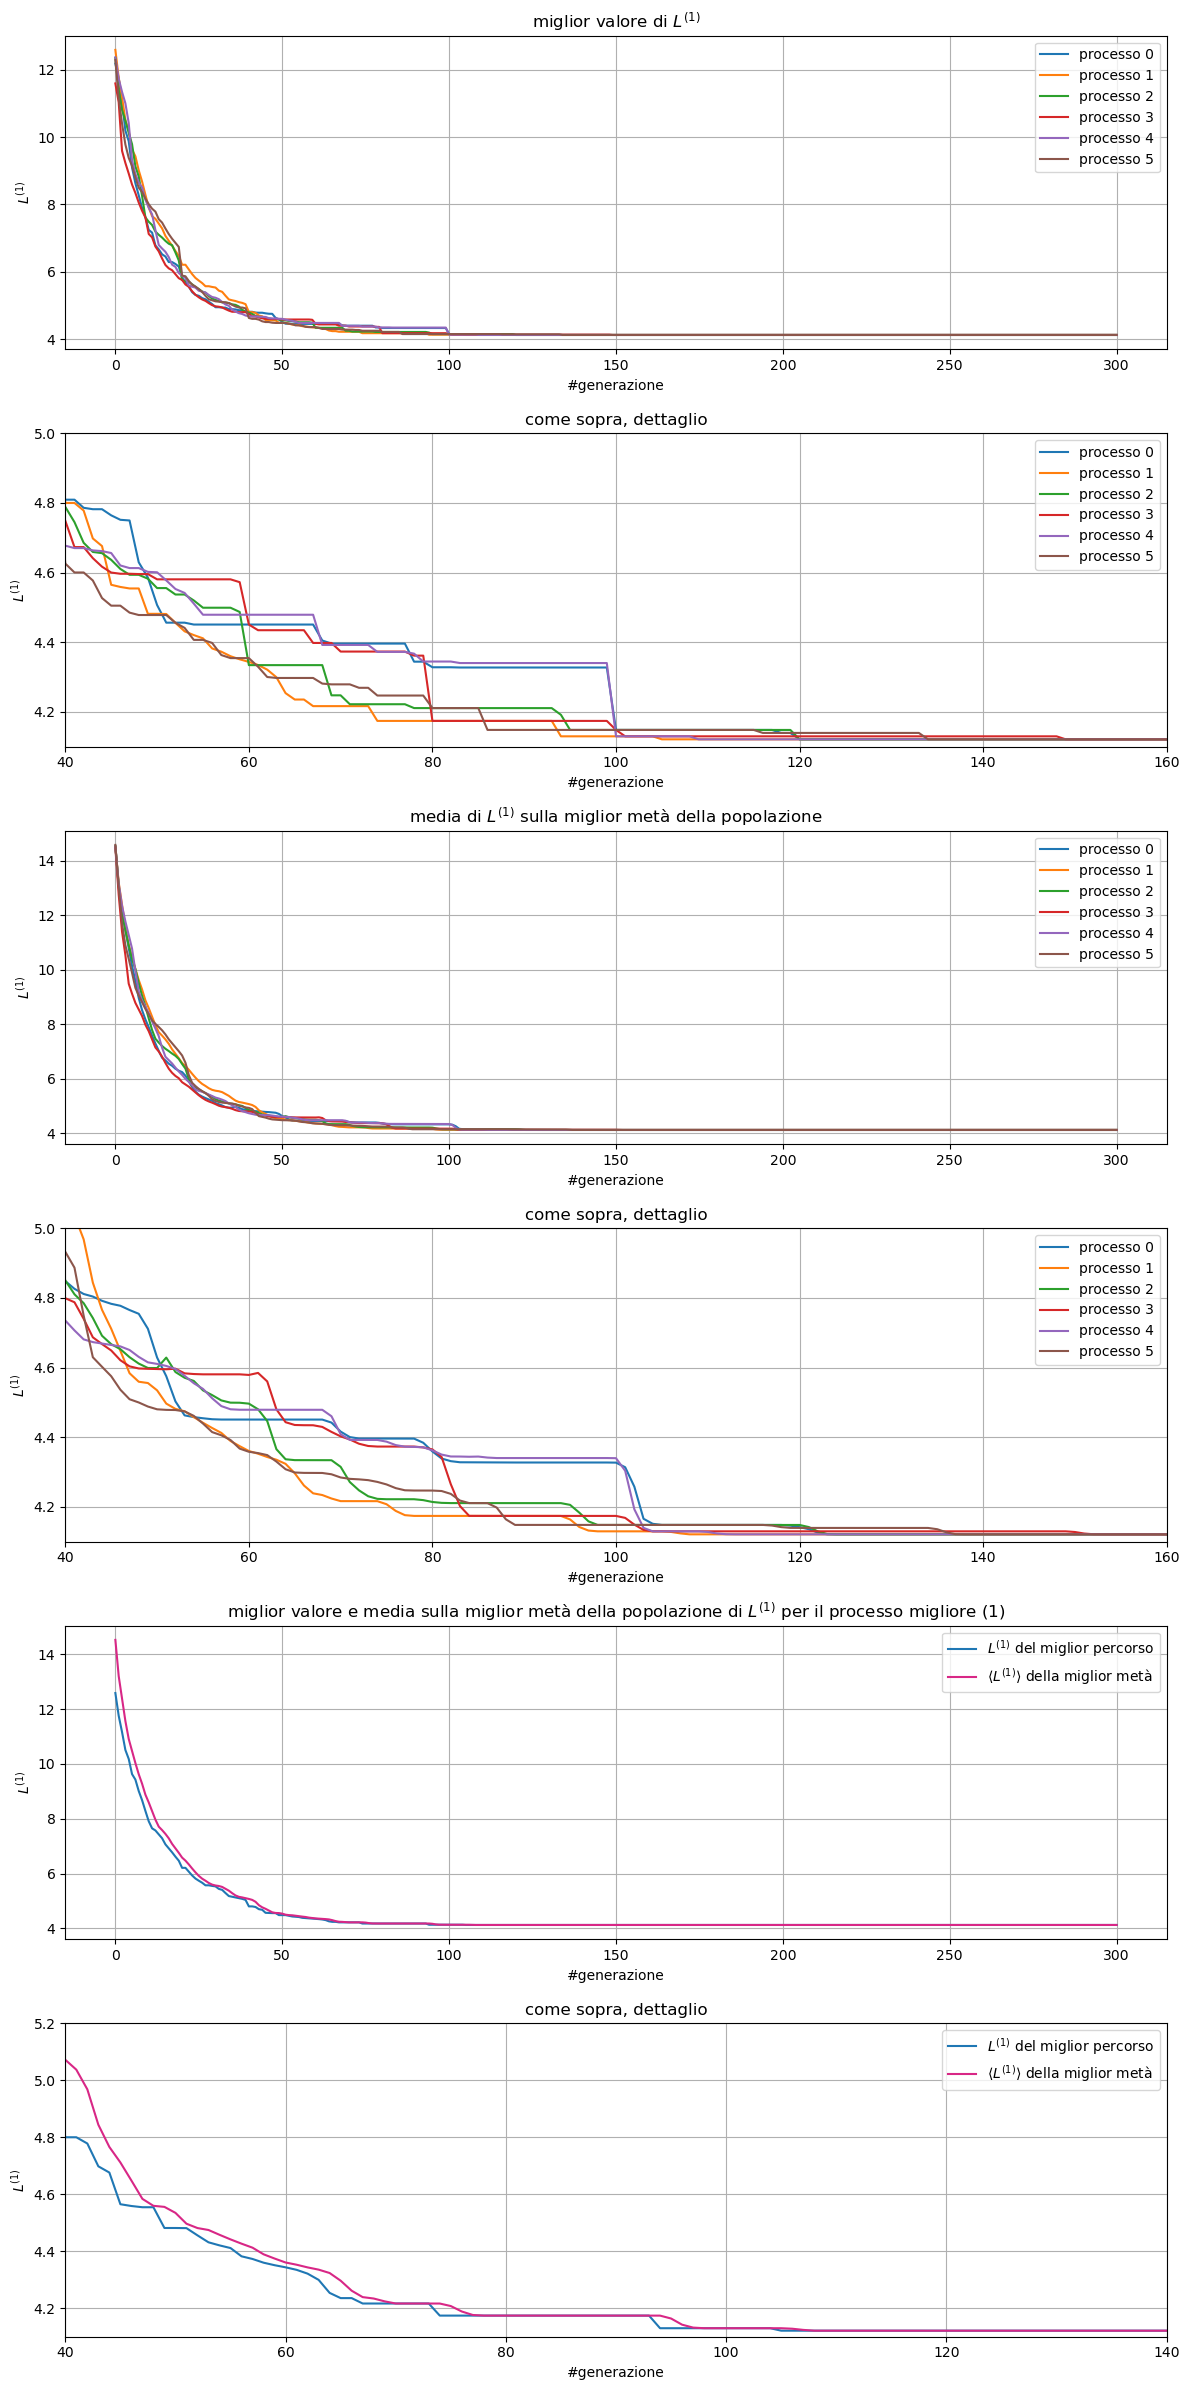

In [7]:
fig, ax = plt.subplots(6, 1, figsize = (12, 24))

bestProc = 0
bestPath = 10000
for i in range(nProcesses):
    # plot best value of L^1 over generations
    best, nGens = loadFile("code/exchange/path_" + str(i) + ".out")
    x = np.arange(nGens)
    ax[0].plot(x, best, label = "processo " + str(i))
    ax[1].plot(x, best, label = "processo " + str(i))

    # plot average value of L^1 on the best half of the populazion over generations
    mean, nGens = loadFile("code/exchange/average_" + str(i) + ".out")
    ax[2].plot(x, mean, label = "processo " + str(i))
    ax[3].plot(x, mean, label = "processo " + str(i))
    
    if (best[-1] < bestPath):
        bestPath = best[-1]
        bestProc = i
        
bestProc = 1

    
# compare best and average for the best process
# (manually selected since in this case all processes converge to the same solution)
best, nGens = loadFile("code/exchange/path_" + str(bestProc) + ".out")
x = np.arange(nGens)
ax[4].plot(x, best, label = "$L^{(1)}$ del miglior percorso")
ax[5].plot(x, best, label = "$L^{(1)}$ del miglior percorso")

mean, nGens = loadFile("code/exchange/average_" + str(bestProc) + ".out")
ax[4].plot(x, mean, color = "#d82786", label = r"$\langle L^{(1)} \rangle$ della miglior metà")
ax[5].plot(x, mean, color = "#d82786", label = r"$\langle L^{(1)} \rangle$ della miglior metà")
    
    
ax[0].set(title = "miglior valore di $L^{(1)}$", xlabel = "#generazione", ylabel = "$L^{(1)}$")
ax[0].legend()
ax[0].grid(True)

ax[1].set(title = "come sopra, dettaglio", xlabel = "#generazione", ylabel = "$L^{(1)}$", xlim = (40, 160), ylim = (4.1, 5))
ax[1].legend()
ax[1].grid(True)

ax[2].set(title = "media di $L^{(1)}$ sulla miglior metà della popolazione", xlabel = "#generazione", ylabel = "$L^{(1)}$")
ax[2].legend()
ax[2].grid(True)

ax[3].set(title = "come sopra, dettaglio", xlabel = "#generazione", ylabel = "$L^{(1)}$", xlim = (40, 160), ylim = (4.1, 5))
ax[3].legend()
ax[3].grid(True)

ax[4].set(title = "miglior valore e media sulla miglior metà della popolazione di $L^{(1)}$ per il processo migliore (%i)" % bestProc, xlabel = "#generazione", ylabel = "$L^{(1)}$")
ax[4].legend()
ax[4].grid(True)

ax[5].set(title = "come sopra, dettaglio", xlabel = "#generazione", ylabel = "$L^{(1)}$", xlim = (40, 140), ylim = (4.1, 5.2))
ax[5].legend()
ax[5].grid(True)


fig.tight_layout()
plt.show()

Da questi grafici risulta evidente la presenta di "salti" verticali in corrispondenza di generazioni multiple di $N_{migr}=20$, cioè quando il miglior cromosoma dei processi in questione cambia perché viene sostituito da quello di un altro processo migliore.  

Il fatto che tutti i processi convergano alla stessa soluzione e vi restino porta a due conclusioni diverse: o abbiamo trovato il minimo assoluto, oppure tutti i processi si trovano in un minimo relativo e, per le caratteristiche dell'algoritmo genetico, nessuno di essi riesce a uscirne. In quest'ultimo caso si tratta sicuramente di un minimo relativo molto stabile, poiché per circa 150 generazioni tutti e 6 i processi tentano di migliorare la soluzione senza riuscirci.  

In ogni caso, facendo comunicare i processi, troviamo una soluzione migliore e la troviamo più in fretta.